<a href="https://colab.research.google.com/github/TANNU-GITHUB/Quantum-Image-Processing-/blob/main/FRQI_vs_NEQR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FRQI

In [7]:
!pip install qiskit qiskit-aer matplotlib

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

# 1. Define the Image
# A 2x2 image has 4 pixels. We define normalized pixel values (0.0 to 1.0).
# Order: Top-Left (00), Top-Right (01), Bottom-Left (10), Bottom-Right (11)
image_pixels = [0.1, 0.9, 0.3, 0.7]

# Convert pixel intensity to rotation angles (theta)
# Equation: theta = 2 * arcsin(sqrt(intensity))
# This ensures probability of measuring |1> equals the intensity.
thetas = [2 * np.arcsin(np.sqrt(p)) for p in image_pixels]

# 2. Build the FRQI Circuit
# We need 2 qubits for position (to address 4 pixels) and 1 qubit for color.
q_pos = QuantumRegister(2, 'position')
q_color = QuantumRegister(1, 'color')
c = ClassicalRegister(3, 'meas')

qc = QuantumCircuit(q_pos, q_color, c)

# Step A: Initialize positions into superposition (Hadamard)
# This allows us to work on all pixels simultaneously.
qc.h(q_pos)
qc.barrier()

# Step B: Encode Color Information
# We iterate through each pixel position and apply a Controlled-Rotation (mcry)
# The rotation is triggered ONLY when the position qubits match the pixel index.

for i, theta in enumerate(thetas):
    # Convert index 'i' to binary string (e.g., 0 -> '00', 1 -> '01')
    binary_state = format(i, '02b')

    # Qiskit orders bits from right-to-left (little-endian), so we reverse the string
    # to match standard image indexing (row-major).
    binary_state = binary_state[::-1]

    # Apply X gates to "0" bits to activate the control on |1>
    for qubit_idx, bit in enumerate(binary_state):
        if bit == '0':
            qc.x(q_pos[qubit_idx])

    # Apply the Multi-Controlled RY rotation to the color qubit
    # This sets the amplitude of the color qubit based on the pixel value.
    qc.mcry(theta, q_pos[:], q_color[0])

    # Reverse the X gates to restore the position state for the next step
    for qubit_idx, bit in enumerate(binary_state):
        if bit == '0':
            qc.x(q_pos[qubit_idx])

    qc.barrier()

#  3. Measurement
# We measure all qubits to retrieve the distribution.
qc.measure(q_pos, c[0:2])  # Measure position
qc.measure(q_color, c[2])  # Measure color

# 4. Draw Circuit
print("Circuit Diagram:")
print(qc.draw(output='text'))

# 5. Simulate and Plot
simulator = AerSimulator()
transpiled_qc = transpile(qc, simulator)
result = simulator.run(transpiled_qc, shots=4096).result()
counts = result.get_counts()


Circuit Diagram:
            ┌───┐ ░      ┌───┐                               ┌───┐ ░ »
position_0: ┤ H ├─░──────┤ X ├───────■────────────────────■──┤ X ├─░─»
            ├───┤ ░      ├───┤       │                    │  ├───┤ ░ »
position_1: ┤ H ├─░──────┤ X ├───────■────────────────────■──┤ X ├─░─»
            └───┘ ░ ┌────┴───┴────┐┌─┴─┐┌──────────────┐┌─┴─┐└───┘ ░ »
     color: ──────░─┤ Ry(0.32175) ├┤ X ├┤ Ry(-0.32175) ├┤ X ├──────░─»
                  ░ └─────────────┘└───┘└──────────────┘└───┘      ░ »
    meas: 3/═════════════════════════════════════════════════════════»
                                                                     »
«                                                       ░      ┌───┐          »
«position_0: ───────────────■──────────────────■────────░──────┤ X ├───────■──»
«                ┌───┐      │                  │  ┌───┐ ░      └───┘       │  »
«position_1: ────┤ X ├──────■──────────────────■──┤ X ├─░──────────────────■──»
«            ┌───┴───┴──

Simulating Quantum Circuit...

Original Pixels:      [0.1 0.9 0.3 0.7]
Reconstructed Pixels: [0.1        0.90409639 0.29049729 0.68509378]
MSE Loss:             0.000082


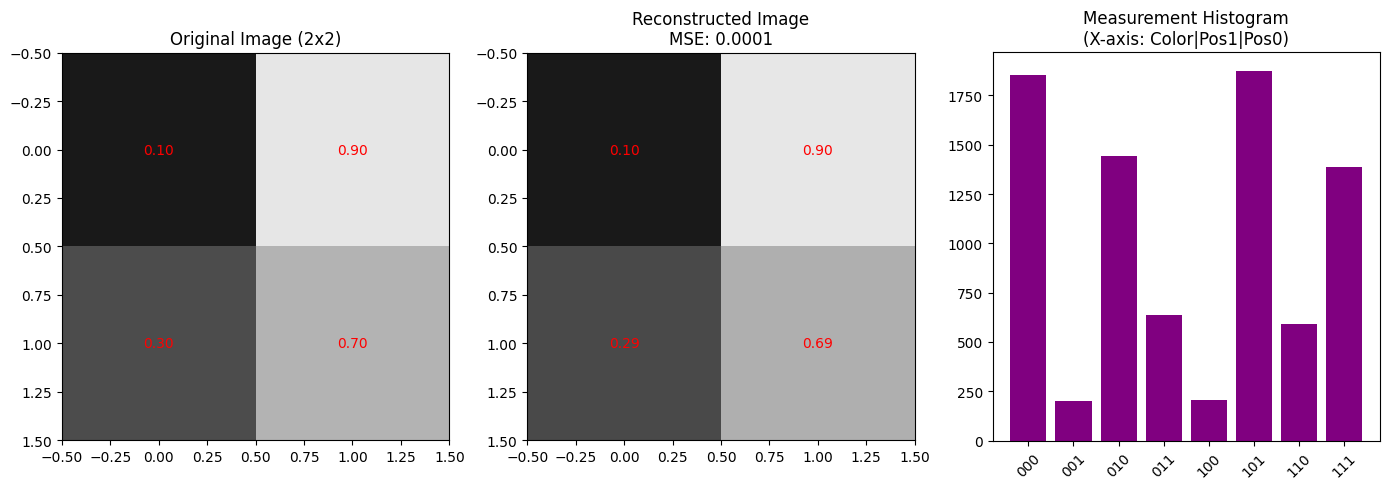

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

# 1. Define the Original Image
original_pixels = np.array([0.1, 0.9, 0.3, 0.7])

# Encode intensities into angles: theta = 2 * arcsin(sqrt(intensity))
# This sets the probability P(1) = intensity.
thetas = [2 * np.arcsin(np.sqrt(p)) for p in original_pixels]

# 2. Build FRQI Circuit
q_pos = QuantumRegister(2, 'pos')
q_color = QuantumRegister(1, 'color')
c = ClassicalRegister(3, 'meas')
qc = QuantumCircuit(q_pos, q_color, c)

# Initialize positions (Hadamard)
qc.h(q_pos)
qc.barrier()

# Encode colors using Controlled-Rotations
for i, theta in enumerate(thetas):
    # Get binary representation of position (e.g., 2 -> '10')
    binary_pos = format(i, '02b')[::-1] # Reverse for Qiskit little-endian

    # Apply X gates to trigger on '0' states
    for idx, bit in enumerate(binary_pos):
        if bit == '0':
            qc.x(q_pos[idx])

    # Apply rotation controlled by position
    qc.mcry(theta, q_pos[:], q_color[0])

    # Reverse X gates
    for idx, bit in enumerate(binary_pos):
        if bit == '0':
            qc.x(q_pos[idx])

    qc.barrier()

# Measure (Order: Color, Pos1, Pos0)
qc.measure(q_pos, c[0:2])
qc.measure(q_color, c[2])

# 3. Simulation
print("Simulating Quantum Circuit...")
simulator = AerSimulator()
transpiled_qc = transpile(qc, simulator)
# Use high shots to minimize statistical noise for MSE calculation
job = simulator.run(transpiled_qc, shots=8192)
result = job.result()
counts = result.get_counts()

#  4. Reconstruction & MSE Calculation
# Initialize counters for reconstruction
# format: pixel_counts[position_index] = {'0': count, '1': count}
pixel_data = {i: {'0': 0, '1': 0} for i in range(4)}

# Parse the counts
# Bitstring format: "Color Pos1 Pos0" (e.g., "101" -> Color=1, Pos=01)
for bitstring, count in counts.items():
    color_bit = bitstring[0]      # Leftmost bit
    pos_bits = bitstring[1:]      # Remaining bits

    # Convert position bits to integer index (remember little-endian)
    # '00'->0, '10'->1, '01'->2, '11'->3 (Raw string order is reversed in int() logic)
    # Correct Qiskit int conversion: int('01', 2) = 1. But our bitstring is Pos1 Pos0.
    pos_idx = int(pos_bits, 2)

    pixel_data[pos_idx][color_bit] += count

# Calculate reconstructed intensity: P(1) = Count(1) / Total_Count
reconstructed_pixels = []
for i in range(4):
    total = pixel_data[i]['0'] + pixel_data[i]['1']
    if total > 0:
        intensity = pixel_data[i]['1'] / total
    else:
        intensity = 0.0
    reconstructed_pixels.append(intensity)

reconstructed_pixels = np.array(reconstructed_pixels)

# Compute Mean Squared Error (MSE)
mse = np.mean((original_pixels - reconstructed_pixels) ** 2)

print(f"\nOriginal Pixels:      {original_pixels}")
print(f"Reconstructed Pixels: {reconstructed_pixels}")
print(f"MSE Loss:             {mse:.6f}")

# 5. Visualization (Original vs Reconstructed + Histogram)
fig = plt.figure(figsize=(14, 5))

# Plot 1: Original Image
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(original_pixels.reshape(2, 2), cmap='gray', vmin=0, vmax=1)
ax1.set_title("Original Image (2x2)")
for (j, i), label in np.ndenumerate(original_pixels.reshape(2, 2)):
    ax1.text(i, j, f"{label:.2f}", ha='center', va='center', color='red')

# Plot 2: Reconstructed Image
ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(reconstructed_pixels.reshape(2, 2), cmap='gray', vmin=0, vmax=1)
ax2.set_title(f"Reconstructed Image\nMSE: {mse:.4f}")
for (j, i), label in np.ndenumerate(reconstructed_pixels.reshape(2, 2)):
    ax2.text(i, j, f"{label:.2f}", ha='center', va='center', color='red')

# Plot 3: Probability Histogram (Raw Counts)
ax3 = fig.add_subplot(1, 3, 3)
# We use Qiskit's plot_histogram but render it into our matplotlib axes
# Note: plot_histogram returns a figure, so we can't easily embed it in subplot
# without some tricks. Instead, we'll plot a simple bar chart of sorted keys.
sorted_keys = sorted(counts.keys())
sorted_vals = [counts[k] for k in sorted_keys]
ax3.bar(sorted_keys, sorted_vals, color='purple')
ax3.set_title("Measurement Histogram\n(X-axis: Color|Pos1|Pos0)")
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

MSE Loss: 0.000262


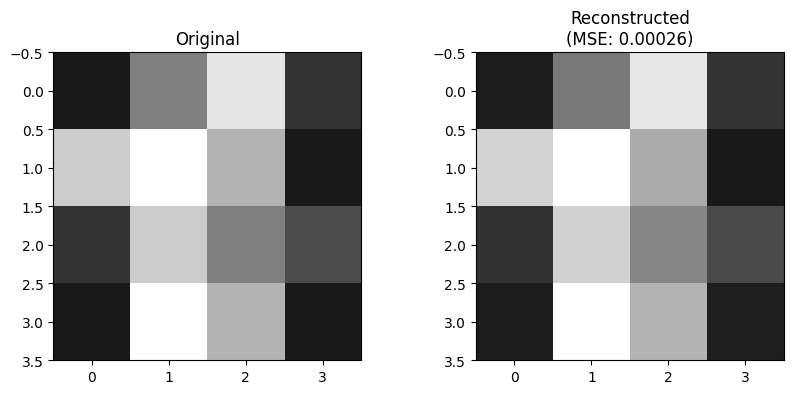

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator

def run_frqi_experiment(image_matrix, shots=10000):
    # 1. Setup Dimensions
    rows, cols = image_matrix.shape
    num_pixels = rows * cols
    # Number of qubits needed for position: log2(total pixels)
    n_pos_qubits = int(np.ceil(np.log2(num_pixels)))

    # Flatten image and calculate thetas
    flat_image = image_matrix.flatten()
    thetas = [2 * np.arcsin(np.sqrt(np.clip(p, 0, 1))) for p in flat_image]

    # 2. Build Circuit
    q_pos = QuantumRegister(n_pos_qubits, 'pos')
    q_color = QuantumRegister(1, 'color')
    c = ClassicalRegister(n_pos_qubits + 1, 'meas')
    qc = QuantumCircuit(q_pos, q_color, c)

    qc.h(q_pos) # Superposition of all positions
    qc.barrier()

    for i, theta in enumerate(thetas):
        if theta == 0: continue # Optimization: skip 0 rotations

        # Binary string for the current pixel index
        binary_pos = format(i, f'0{n_pos_qubits}b')[::-1]

        # Flip qubits to '1' for the multi-controlled gate
        for idx, bit in enumerate(binary_pos):
            if bit == '0': qc.x(q_pos[idx])

        # Multi-Controlled RY
        qc.mcry(theta, q_pos[:], q_color[0])

        # Flip back
        for idx, bit in enumerate(binary_pos):
            if bit == '0': qc.x(q_pos[idx])
        qc.barrier()

    # 3. Measurement (Color is the highest order bit in our logic)
    qc.measure(q_pos, c[0:n_pos_qubits])
    qc.measure(q_color, c[n_pos_qubits])

    # 4. Simulation
    backend = AerSimulator()
    t_qc = transpile(qc, backend)
    counts = backend.run(t_qc, shots=shots).result().get_counts()

    # 5. Reconstruction
    reconstructed = np.zeros(num_pixels)
    for i in range(num_pixels):
        pos_bin = format(i, f'0{n_pos_qubits}b')

        # Extract counts where color was 1 vs 0 for this specific position
        # Qiskit bitstring: [Color][Pos_N...Pos_0]
        c1 = counts.get('1' + pos_bin, 0)
        c0 = counts.get('0' + pos_bin, 0)

        total = c1 + c0
        reconstructed[i] = c1 / total if total > 0 else 0

    reconstructed_matrix = reconstructed.reshape(rows, cols)
    mse = np.mean((image_matrix - reconstructed_matrix)**2)

    return reconstructed_matrix, mse, counts, qc

# Execution Example
# You can put any 2^n x 2^n matrix here
my_image = np.array([
    [0.1, 0.5,0.9,0.2],
    [0.8, 1.0, 0.7, 0.1],
    [0.2, 0.8, 0.5, 0.3],
    [0.1, 1.0, 0.7, 0.1]
])

recon_img, mse_loss, final_counts, final_qc = run_frqi_experiment(my_image, shots=15000)

# --- Visualization ---
print(f"MSE Loss: {mse_loss:.6f}")
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(my_image, cmap='gray', vmin=0, vmax=1)
ax[0].set_title("Original")
ax[1].imshow(recon_img, cmap='gray', vmin=0, vmax=1)
ax[1].set_title(f"Reconstructed\n(MSE: {mse_loss:.5f})")
plt.show()

## NEQR

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator

# 1. Define the Image (0-255 scale for NEQR)
# For a 2x2 image, we have 4 pixels.
image_pixels = [25, 230, 75, 180]

#  2. Build NEQR Circuit
# 2 qubits for position, 8 qubits for color (intensity 0-255)
q_pos = QuantumRegister(2, 'pos')
q_color = QuantumRegister(8, 'color')
c = ClassicalRegister(10, 'meas')
qc = QuantumCircuit(q_pos, q_color, c)

# Step A: Position Superposition
qc.h(q_pos)
qc.barrier()

# Step B: Encode Color Digitally
for i, val in enumerate(image_pixels):
    binary_pos = format(i, '02b')[::-1]
    binary_val = format(val, '08b')[::-1] # 8-bit intensity

    # Set up controls for the specific pixel position
    for idx, bit in enumerate(binary_pos):
        if bit == '0': qc.x(q_pos[idx])

    # Apply Multi-Controlled Not (Toffoli) to set the '1's in color bitstring
    for idx, bit in enumerate(binary_val):
        if bit == '1':
            qc.mcx(q_pos[:], q_color[idx])

    # Reset controls
    for idx, bit in enumerate(binary_pos):
        if bit == '0': qc.x(q_pos[idx])
    qc.barrier()

#  3. Measurement
qc.measure(q_pos, c[0:2])
qc.measure(q_color, c[2:10])

print("NEQR Circuit (Partial view):")
print(qc.draw(output='text', idle_wires=False))

#  4. Simulation
simulator = AerSimulator()
counts = simulator.run(transpile(qc, simulator), shots=4096).result().get_counts()
print("\nSimulation complete. Use Segment 2 to reconstruct.")

NEQR Circuit (Partial view):
         ┌───┐ ░ ┌───┐               ┌───┐ ░                               »
  pos_0: ┤ H ├─░─┤ X ├──■────■────■──┤ X ├─░────────■────■────■────■────■──»
         ├───┤ ░ ├───┤  │    │    │  ├───┤ ░ ┌───┐  │    │    │    │    │  »
  pos_1: ┤ H ├─░─┤ X ├──■────■────■──┤ X ├─░─┤ X ├──■────■────■────■────■──»
         └───┘ ░ └───┘┌─┴─┐  │    │  └───┘ ░ └───┘  │    │    │    │    │  »
color_0: ──────░──────┤ X ├──┼────┼────────░────────┼────┼────┼────┼────┼──»
               ░      └───┘  │    │        ░      ┌─┴─┐  │    │    │    │  »
color_1: ──────░─────────────┼────┼────────░──────┤ X ├──┼────┼────┼────┼──»
               ░             │    │        ░      └───┘┌─┴─┐  │    │    │  »
color_2: ──────░─────────────┼────┼────────░───────────┤ X ├──┼────┼────┼──»
               ░           ┌─┴─┐  │        ░           └───┘  │    │    │  »
color_3: ──────░───────────┤ X ├──┼────────░──────────────────┼────┼────┼──»
               ░           └───┘┌─┴─┐      ░   

Original: [ 25 230  75 180]
Reconstructed: [ 25. 230.  75. 180.]
MSE Loss: 0.0


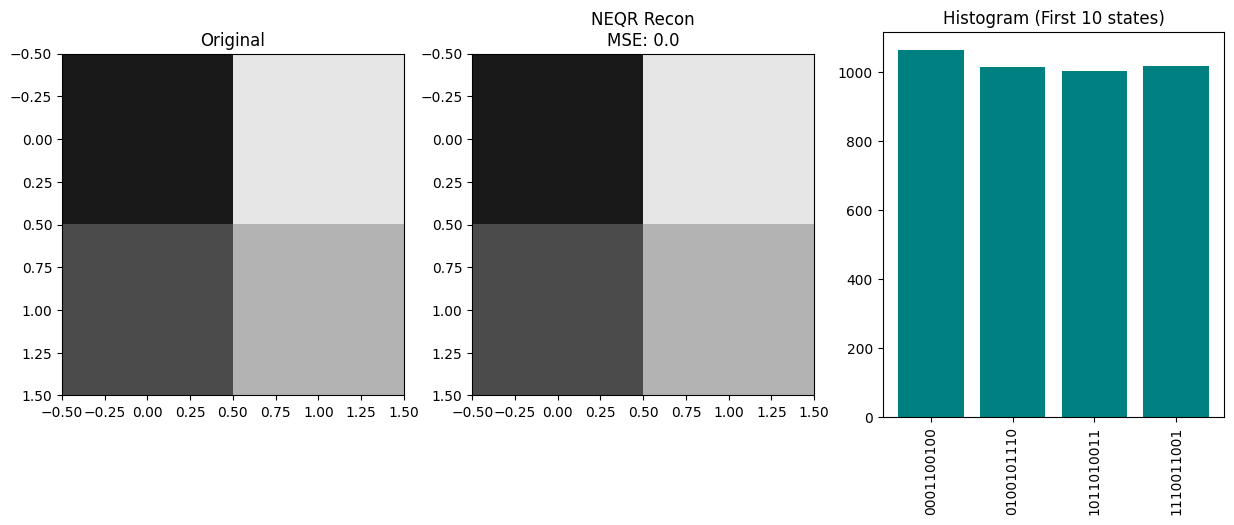

In [17]:
# 1. Reconstruction Logic
reconstructed_pixels = np.zeros(4)

# NEQR Bitstring format: [Color 7-0][Pos 1-0]
for bitstring, count in counts.items():
    color_bits = bitstring[0:8] # First 8 bits
    pos_bits = bitstring[8:10]  # Last 2 bits

    # Convert binary to decimal
    pos_idx = int(pos_bits, 2)
    # Binary is reversed in our encoding loop, so we handle it here
    intensity = int(color_bits, 2)

    reconstructed_pixels[pos_idx] = intensity

# 2. MSE Calculation
original_pixels = np.array(image_pixels)
mse = np.mean((original_pixels - reconstructed_pixels) ** 2)

print(f"Original: {original_pixels}")
print(f"Reconstructed: {reconstructed_pixels}")
print(f"MSE Loss: {mse}")

#  3. Visualization
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Original
ax1.imshow(original_pixels.reshape(2,2), cmap='gray', vmin=0, vmax=255)
ax1.set_title("Original")

# Reconstructed
ax2.imshow(reconstructed_pixels.reshape(2,2), cmap='gray', vmin=0, vmax=255)
ax2.set_title(f"NEQR Recon\nMSE: {mse}")

# Histogram
sorted_counts = dict(sorted(counts.items(), key=lambda item: item[0]))
ax3.bar(list(sorted_counts.keys())[:10], list(sorted_counts.values())[:10], color='teal')
ax3.set_title("Histogram (First 10 states)")
plt.xticks(rotation=90)
plt.show()

MSE Loss: 0.0
Success: Reconstruction is perfect!


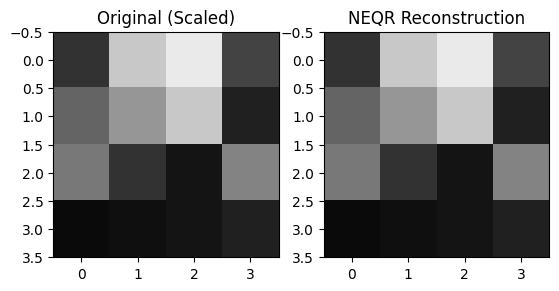

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator

def run_neqr_experiment_fixed(image_matrix, bit_depth=8, shots=20000):
    # 1. Prepare Data
    rows, cols = image_matrix.shape
    num_pixels = rows * cols
    n_pos_qubits = int(np.ceil(np.log2(num_pixels)))

    # Ensure image is in 0-255 integer format for NEQR
    if image_matrix.max() <= 1.0:
        image_matrix = (image_matrix * 255).astype(int)
    else:
        image_matrix = image_matrix.astype(int)

    # 2. Setup Registers
    # Using specific registers to avoid indexing confusion
    q_pos = QuantumRegister(n_pos_qubits, 'pos')
    q_color = QuantumRegister(bit_depth, 'color')
    c_meas = ClassicalRegister(n_pos_qubits + bit_depth, 'm')
    qc = QuantumCircuit(q_pos, q_color, c_meas)

    # Superposition for positions
    qc.h(q_pos)
    qc.barrier()

    # 3. Encoding Logic
    flat_image = image_matrix.flatten()
    for i, intensity in enumerate(flat_image):
        if intensity == 0: continue # All color qubits stay |0> by default

        # Binary strings (Little-endian to match Qiskit)
        bin_pos = format(i, f'0{n_pos_qubits}b')[::-1]
        bin_val = format(int(intensity), f'0{bit_depth}b')[::-1]

        # Select this specific pixel position
        for idx, bit in enumerate(bin_pos):
            if bit == '0':
                qc.x(q_pos[idx])

        # Multi-Controlled X for each '1' in intensity
        for idx, bit in enumerate(bin_val):
            if bit == '1':
                qc.mcx(q_pos[:], q_color[idx])

        # Restore position qubits
        for idx, bit in enumerate(bin_pos):
            if bit == '0':
                qc.x(q_pos[idx])
        qc.barrier()

    # 4. Measurement
    # Map color to first bits of classical register, position to the rest
    qc.measure(q_color, c_meas[0:bit_depth])
    qc.measure(q_pos, c_meas[bit_depth:])

    # 5. Simulation
    backend = AerSimulator()
    t_qc = transpile(qc, backend)
    counts = backend.run(t_qc, shots=shots).result().get_counts()

    # 6. Reconstruction
    reconstructed_flat = np.zeros(num_pixels)

    for bstr, count in counts.items():
        # Based on our measure() call:
        # bstr is [Pos][Color] from left to right in the string
        pos_part = bstr[0:n_pos_qubits]
        col_part = bstr[n_pos_qubits:]

        idx = int(pos_part, 2)
        val = int(col_part, 2)

        # We assign the value found in the majority of shots for that position
        reconstructed_flat[idx] = val

    recon_matrix = reconstructed_flat.reshape(rows, cols)
    mse = np.mean((image_matrix - recon_matrix)**2)

    return recon_matrix, mse, image_matrix

# Execution
# use a 2x2 for speed, but this works for 4x4, 8x8 etc.
sample_matrix = np.array([
    [50, 200,234, 67],
     [100, 150,200,32],
    [120, 50,20,132],
    [10, 15,20,32]
    ])
recon, mse_loss, original_scaled = run_neqr_experiment_fixed(sample_matrix)

print(f"MSE Loss: {mse_loss}")
if mse_loss == 0:
    print("Success: Reconstruction is perfect!")

# Visualization
fig, ax = plt.subplots(1, 2)
ax[0].imshow(original_scaled, cmap='gray', vmin=0, vmax=255)
ax[0].set_title("Original (Scaled)")
ax[1].imshow(recon, cmap='gray', vmin=0, vmax=255)
ax[1].set_title("NEQR Reconstruction")
plt.show()